# A 3D mapping of Felllagi Forest Height

In [ ]:
In the next lines of codes, 

#### Load the required packages

In [2]:
libs <- c(
  "tidyverse", "sf", "geodata","terra", "classInt", "rayshader")

In [3]:
installed_libs <- libs %in% rownames(
  installed.packages()
)

In [4]:
if(any(installed_libs == F)){
  install.packages(
    libs[!installed_libs])
}
invisible(lapply(
  libs,
  library,
  character.only = T
))

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE

Loading required package: terra

terra 1.7.78


Attaching package: 'terra'


The following object is masked from 'package:tidyr':

    extract




#### Set the working directory

In [10]:
setwd('C:/Users/Ezekiel Godwin/Downloads/Projects/Tree_Height')

In [11]:
getwd()

[1] "C:/Users/Ezekiel Godwin/Downloads/Projects/Tree_Height"

#### Load the files
- Forest height raster file: Downloaded ETH Global canopy map
- Area of interest: Administrative boundary of Fellagi Forest, Kainji, Niger State, Nigeria (_Prepared in QGIS_)

In [12]:
raster_file <- list.files(path = getwd(), pattern = "ETH", full.names = T)

In [17]:
raster_file

[1] "C:/Users/Ezekiel Godwin/Downloads/Projects/Tree_Height/ETH_GlobalCanopyHeight_10m_2020_N09E003_Map.tif"

In [13]:
aoi_boundary <- "C:/Users/Ezekiel Godwin/Dropbox/PC/Downloads/Projects/Tree_Height/nig_for.shp"

In [14]:
forest <- st_read(aoi_boundary, options = "ENCODING=UTF-8")

options:        ENCODING=UTF-8 
Reading layer `nig_for' from data source 
  `C:\Users\Ezekiel Godwin\Dropbox\PC\Downloads\Projects\Tree_Height\nig_for.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 4.703402 ymin: 9.663687 xmax: 5.32361 ymax: 9.996321
Geodetic CRS:  WGS 84


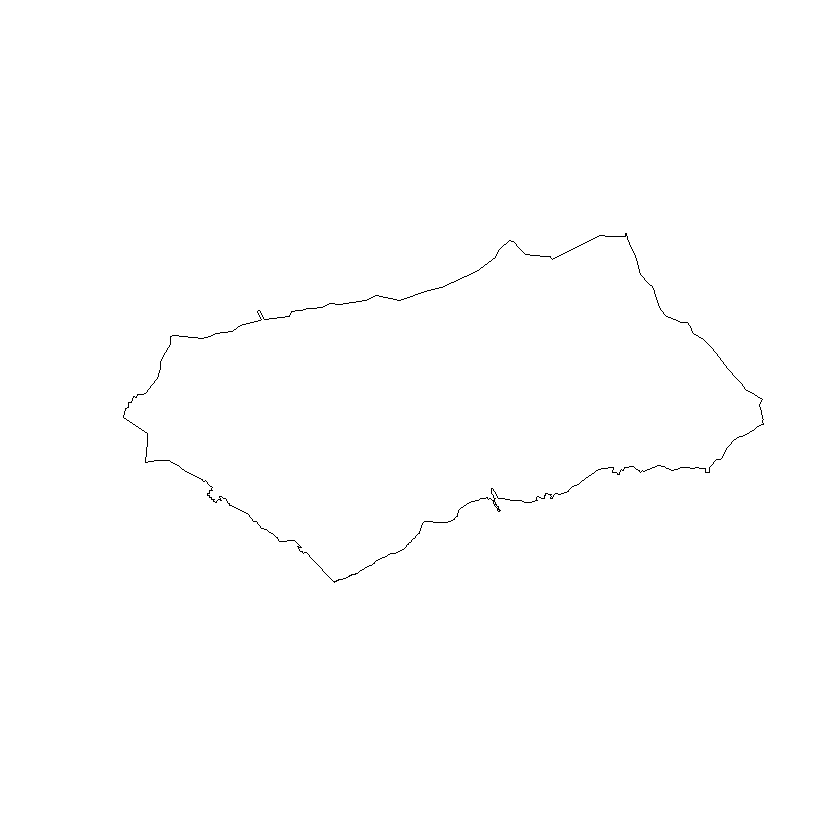

In [15]:
plot(st_geometry(forest))

#### Convert the Forest Height raster into a SpatRaster and the aoi boundary(.shp) into a SpatVector <br>
 N.B: SpatRaster & SpatVector are the primary object types in the _terra_ package

In [18]:
fh_rast <- rast(raster_file)

In [19]:
forest_bd <- vect(shapefile_path)

#### Aggregate the raster and clip it to the aoi boundary

In [36]:
fh_agg <- aggregate(fh_rast, fact = 10, fun = mean)

In [21]:
fh_forest <- crop(fh_agg, forest_bd, snap = "in")

In [24]:
forest_masked <- mask(fh_forest, forest_bd)

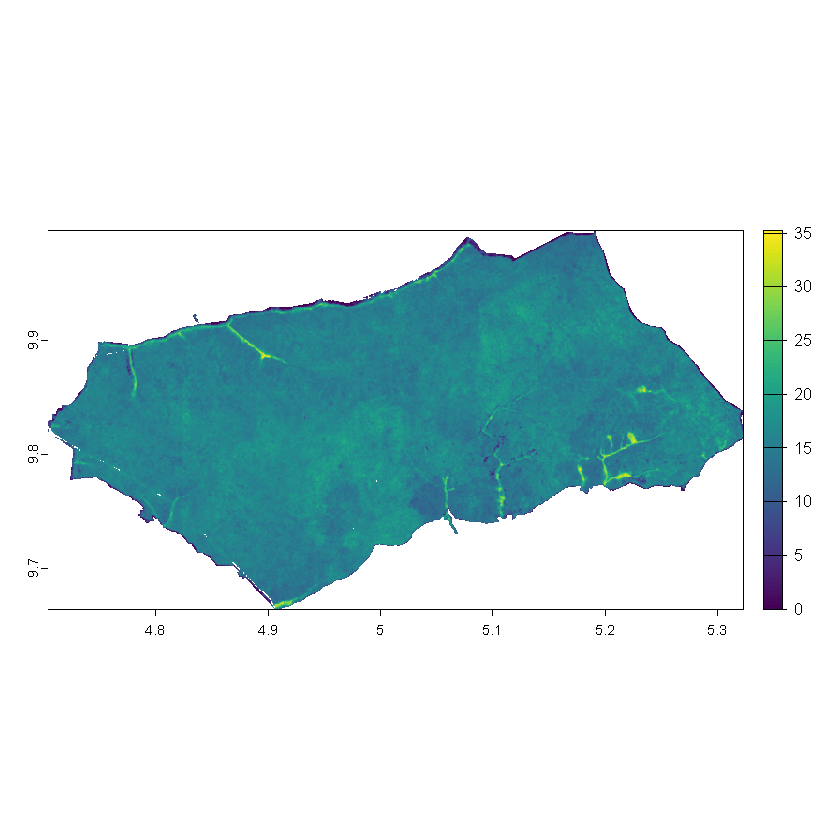

In [25]:
plot(forest_masked)

#### Create a dataframe from the clipped raster

In [26]:
fh_df <- as.data.frame(forest_masked, xy = TRUE)

In [35]:
head(fh_df)

,x,y,height
,<dbl>,<dbl>,<dbl>
583,5.189583,9.995417,2.70
584,5.190417,9.995417,1.29
1296,5.164583,9.994583,0.14
1297,5.165417,9.994583,0.00
1298,5.166250,9.994583,0.00
1299,5.167083,9.994583,0.00


#### Specify the height column and define the height class intervals

In [28]:
colnames(fh_df) <- c("x", "y", "height")

In [29]:
breaks <- classInt::classIntervals(
  fh_df$height,
  n = 5,
  style = "fisher"
)$brks

#### Create the visualization parameters

In [31]:
cols <-
  c(
    "white", "#ffd3af", "#fbe06e",
    "#6daa55", "#205544"
  )

In [ ]:
texture <- colorRampPalette(
  cols,
  bias = 2
)(6)

In [ ]:
p <- ggplot(
  fh_df
) +
 geom_tile(
    aes(
      x = x,
      y = y,
      fill = height
      )
  )+
  scale_fill_gradientn(
    name = "height (m)",
    colors = texture,
    breaks = round(breaks, 0)
)+
coord_sf(crs = 4326)+
  guides(
    fill = guide_legend(
      direction = "vertical",
      keyheight = unit(5, "mm"),
      keywidth = unit(5, "mm"),
      title.position = "top",
      label.position = "right",
      title.hjust = 0.5,
      label.hjust = 0.5,
      ncol = 1,
      byrow = FALSE
    )
) +
theme_minimal() +
theme(
  axis.line = element_blank(),
  axis.title.x = element_blank(), 
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  legend.position ="right",
  legend.title = element_text(size = 11, color = "grey10"),
  legend.text = element_text(size = 11, color = "grey10"),
  panel.grid.major = element_line(color = "white"),
  plot.background = element_rect(fill = "white", color = NA),
  panel.border = element_rect(fill = NA, color = "white"),
  plot.margin = unit(c(t = 0, r = 0, b = 0, l = 0), "lines")
)

In [ ]:
h <- nrow(fh_df)
w <- ncol(fh_df)

In [ ]:
max_dimension <- 50  # Maximum dimension in inches

# Calculate the aspect ratio
aspect_ratio <- w / h

# Adjust width and height to fit within the maximum dimension
if (aspect_ratio > 1) {
  width_in_inches <- max_dimension
  height_in_inches <- max_dimension / aspect_ratio
} else {
  height_in_inches <- max_dimension
  width_in_inches <- max_dimension * aspect_ratio
}

In [ ]:
options(ragg.max_dim = 10000)  # Set a higher max dimension (e.g., 100,000 pixels)

rayshader::plot_gg(
  ggobj = p,
  width = 10,
  height = 10,
  scale = 150,
  solid = FALSE,
  soliddepth = 0,
  shadow = TRUE, 
  shadow_intensity =0.99,
  offset_edges = FALSE,
  sunangle = 315,
  #window.size = c(800, 800),
  zoom = 0.4,
  phi = 30,
  theta = -30,
  multicore = TRUE
)

#### Render the image  for better visualization

In [ ]:
rayshader::render_camera(
  phi = 50,
  zoom = .7,
  theta = 45
)

In [ ]:
ggplot2::ggsave(
  filename = "niger-forest-height-2020.png",
  plot = last_plot(),  # Assuming the plot is the last one created
  width = 10,  # Adjust width to desired size (in pixels)
  height = 10,  # Adjust height to desired size (in pixels)
  dpi = 300,  # Set the DPI (dots per inch) for resolution
  limitsize = FALSE  # Override size limit
)

In [ ]:
rayshader::render_highquality(
  filename = "niger-forest-height-2020.png",
  preview = TRUE,
  interactive = FALSE,
  light = TRUE,
  lightdirection = c(
    315, 310, 315, 310
  ),
  lightintensity = c(
    1000, 1500, 150, 100
  ),
  lightaltitude = c(
    15, 15, 80, 80
  ),
  ground_material =
  rayrender::microfacet(
    roughness = 0.6
  ),
  width = 10,
  height = 10,
)

In [56]:
library(png)
library(grid)

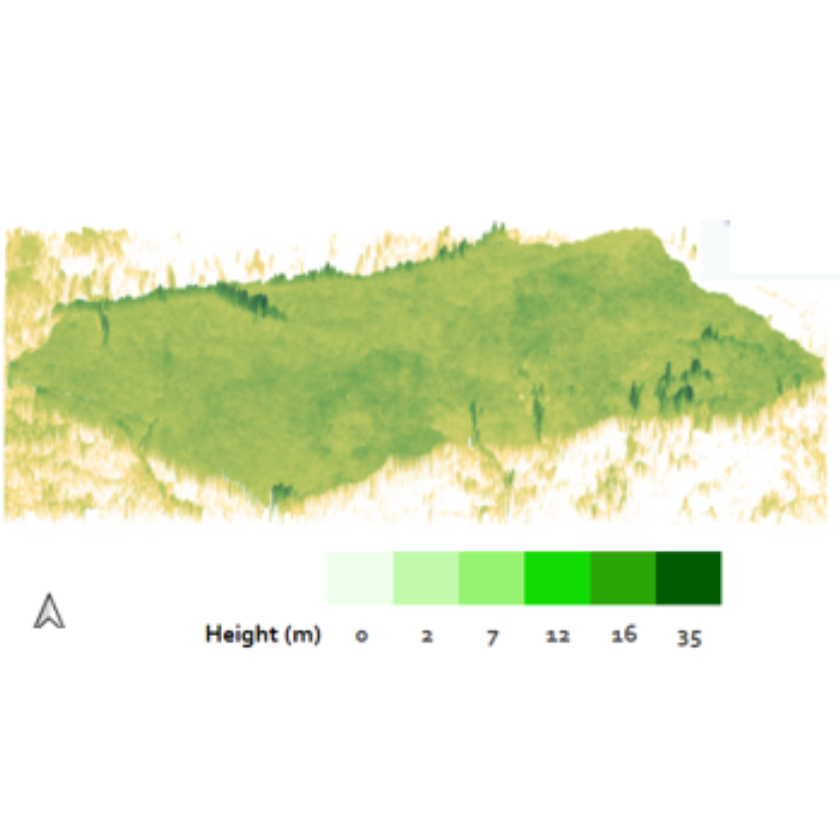

In [55]:
image_path <- "C:/Users/Ezekiel Godwin/Downloads/Projects/Tree_Height/tree_ht.png"

# Read the image
img <- readPNG(image_path)

# Display the image
grid.raster(img)

_Reference_: https://www.youtube.com